<a href="https://colab.research.google.com/github/Menna13/anime-genre-classification/blob/main/Base_Anime_Genre_Classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
pip install Unidecode

### Imports and Libraries

In [ ]:

import json
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import pandas as pd
from unidecode import unidecode
import nltk
from nltk import word_tokenize
from nltk.corpus import stopwords
import string
import os
import urllib.request
import matplotlib.pyplot as plt
from scipy import spatial
from sklearn.manifold import TSNE
import numpy as np
from keras.layers import LSTM, Activation, Dropout, Dense, Input, Conv1D, MaxPooling1D, GlobalMaxPooling1D
from keras.layers.embeddings import Embedding
from keras.models import Model
import re
from keras.preprocessing.text import Tokenizer
from sklearn.preprocessing import LabelBinarizer
from keras.preprocessing.sequence import pad_sequences
from sklearn.model_selection import train_test_split
from itertools import chain
nltk.download('stopwords')
nltk.download('punkt')
import collections
from sklearn.preprocessing import LabelEncoder
from keras.utils import np_utils
from keras.models import Sequential
from keras.wrappers.scikit_learn import KerasClassifier
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold
from sklearn.pipeline import Pipeline

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


### Loading Data

In this code we read our anime dataframe using the url and keep only synopsis and genre columns and drop the null rows. 

In [ ]:
#importing anime dataset from our github repository
url = 'https://raw.githubusercontent.com/Menna13/anime-genre-classification/main/animes.csv'
anime_df = pd.read_csv(url)
data = anime_df[['synopsis', 'genre']]
# delete all rows that has null genre
# TODO: get how many null values dropped to include in paper
data = data.dropna()

In the next two cells, we read the glove 200 dimension embeddings and unzip them 

In [ ]:
urllib.request.urlretrieve('https://nlp.stanford.edu/data/glove.6B.zip','glove.6B.zip')

('glove.6B.zip', <http.client.HTTPMessage at 0x7fb450e2e490>)

In [ ]:
!unzip "/content/glove.6B.zip" -d "/content/"

Archive:  /content/glove.6B.zip
replace /content/glove.6B.50d.txt? [y]es, [n]o, [A]ll, [N]one, [r]ename: no
replace /content/glove.6B.100d.txt? [y]es, [n]o, [A]ll, [N]one, [r]ename: no
replace /content/glove.6B.200d.txt? [y]es, [n]o, [A]ll, [N]one, [r]ename: no
replace /content/glove.6B.300d.txt? [y]es, [n]o, [A]ll, [N]one, [r]ename: no


### Clean Genre Table

We then clean the genre column in our dataframe through creating a new column called genre_first that contains the first genre of each synopsis. 

We encountered an issue with sci-fi. The tokenizer later considere sci-fi two seperate tokens, resulting in sci and fi as both being in the label to sequence map. So we solve this by changing Sci-Fi to SciFi whenever it's encountered as the first indexed genre

In [ ]:
# -*- coding: utf-8 -*-
"""Anime Genre Classification.ipynb

Automatically generated by Colaboratory.

Original file is located at
    https://colab.research.google.com/drive/1K09TskXUW2iQIqP1JyNmCwKHDi9d0wB7
"""
DATASIZE = 18000
MAXLEN = 150

# anime_df = pd.read_csv('animes.csv', encoding='UTF-8')
genres_set = set() 
data['genre_first'] = data['genre']
for j, genre in enumerate(data['genre']):
    # split genre by ',' and igonre first and last characters which are (' and ')
    s = genre[1:-1].split(',')
    for i, word in enumerate(s):
        stripped = word.replace('\'', '').replace(' ', '')
        if i == 0:
            if stripped=='Sci-Fi':
              stripped= 'SciFi'
            data.at[j, 'genre_first'] = stripped
        genres_set.add(stripped)
# Total of 43 genre



* TABLE LENGTH: 
> 18,287

* GENRES: ***43***,  but since 2 genres (ShoujoAi, Yuri) never appeared as first genre, we consider len of genres to be 41 in single label classifiaction 
> 'Horror', 'Drama', 'Yaoi', 'Music', 'Police', 'ShounenAi', 'School', 'SuperPower', 'Hentai', 'Psychological', 'Space', 'Cars', 'Romance', 'Ecchi', 'Comedy', 'Sports', 'Demons', 'Magic', 'Adventure', 'MartialArts', 'Historical', 'Mecha', 'Military', 'SliceofLife', 'Parody', 'Vampire', 'Fantasy', 'Shounen', 'Kids', 'Game', 'Thriller', 'Josei', 'Sci-Fi', 'Seinen', 'Supernatural', 'Action', 'Mystery', 'Shoujo', 'Harem', 'Dementia', 'Samurai'




  

### Clean and Preprocess Synopsis

We then clean the synopsis column in our dataframe through creating a new column called synopsis2 that contains synopsis without stop words, tags, punctuation, etc. 


In [ ]:
# Preprocess Synopsis
data['synopsis'] = data['synopsis'].str.lower()

stopwords = ["a", "about", "above", "after", "again", "against", "all", "am", "an", "and", "any", "are", "as", "at", "be", "because",
             "been", "before", "being", "below", "between", "both", "but", "by", "could", "did", "do", "does", "doing", "down", "during",
             "each", "few", "for", "from", "further", "had", "has", "have", "having", "he", "he'd", "he'll", "he's", "her", "here",
             "here's", "hers", "herself", "him", "himself", "his", "how", "how's", "i", "i'd", "i'll", "i'm", "i've", "if", "in", "into",
             "is", "it", "it's", "its", "itself", "let's", "me", "more", "most", "my", "myself", "nor", "of", "on", "once", "only", "or",
             "other", "ought", "our", "ours", "ourselves", "out", "over", "own", "same", "she", "she'd", "she'll", "she's", "should",
             "so", "some", "such", "than", "that", "that's", "the", "their", "theirs", "them", "themselves", "then", "there", "there's",
             "these", "they", "they'd", "they'll", "they're", "they've", "this", "those", "through", "to", "too", "under", "until", "up",
             "very", "was", "we", "we'd", "we'll", "we're", "we've", "were", "what", "what's", "when", "when's", "where", "where's",
             "which", "while", "who", "who's", "whom", "why", "why's", "with", "would", "you", "you'd", "you'll", "you're", "you've",
             "your", "yours", "yourself", "yourselves"]


def remove_stopwords(data):
    data['synopsis2'] = data['synopsis'].apply(lambda x: ' '.join(
        [word for word in x.split() if word not in (stopwords)]))
    return data


def remove_tags(string):
    result = re.sub('<.*?>', '', string)
    return result


print("removing stopwords...")
clean = remove_stopwords(data)
print("removed stopwords...")

print("removing tags...")
clean['synopsis2'] = clean['synopsis2'].apply(lambda cw: remove_tags(cw))
print("removed tags...")
clean['synopsis2'] = clean['synopsis2'].str.replace(
    '[{}]'.format(string.punctuation), ' ')

synopses = clean['synopsis2']
# print(synopses)

synopsis_list = list(synopses)







removing stopwords...
removed stopwords...
removing tags...
removed tags...


### Exploratory Data Analysis


> Top 5 Genres:Action, Comedy, Hentai, Adventure, Music



RUN THIS CELL: 
in this section, we create a pie chart to show the top 5 genres in terms of frequency. We create two pie charts, one including all genres and another combining all genres other than the top 5 to an 'Other' category. 

            Genre  Freq
3          Action  4034
0          Comedy  3227
32         Hentai  1977
4       Adventure  1541
14          Music  1280
6     SliceofLife   923
20           Kids   913
1           Drama   885
7         Fantasy   568
2           SciFi   500
21       Dementia   305
16     Historical   238
5         Mystery   206
18         Sports   172
17           Game   165
8         Romance   157
23          Harem   154
9           Ecchi   146
10       Military   113
12          Magic   108
28          Mecha    87
15         Horror    81
26         Demons    81
29         Parody    76
13           Cars    59
11         School    58
27   Supernatural    54
19  Psychological    49
24          Space    34
31        Shounen    21
36         Police    14
30     SuperPower    10
39         Seinen     9
38         Shoujo     8
40        Samurai     8
37    MartialArts     7
22          Josei     6
25       Thriller     4
34           Yaoi     4
33        Vampire     3
35      ShounenA

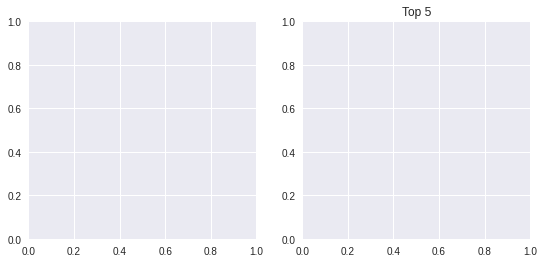

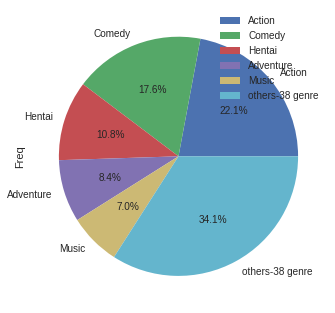

In [ ]:
genre_freq = collections.Counter(data['genre_first'])
chart_df = pd.DataFrame(
    data = {'Genre':genre_freq.keys(), 'Freq':genre_freq.values()}
    ).sort_values('Freq', ascending = False)
print(chart_df)

#the top 5
chart_df2 = chart_df[:5].copy()

#others
new_row = pd.DataFrame(data = {
    'Genre' : ['others-38 genre'],
    'Freq' : [chart_df['Freq'][5:].sum()]
})

chart_df2 = pd.concat([chart_df2, new_row])

#plotting -- for comparison: left all genres and right top 5

fig, axes = plt.subplots(nrows = 1, ncols = 2, figsize = (9,4))
# chart_df.plot(kind = 'pie', y = 'Freq', labels = chart_df['Genre'], ax = axes[0])
chart_df2.plot(kind = 'pie', y = 'Freq', labels = chart_df2['Genre'], autopct='%1.1f%%')
# axes[0].set_title('All Genre')
axes[1].set_title('Top 5')
plt.show()

# chart_label = np.array(list(genre_freq.keys()))
# chart_val = np.array(list(genre_freq.values()))
# plt.pie(chart_val, labels = chart_label)
# # plt.legend()
# plt.show() 

### Generating Training and Labels Lists and Tokenizers

In this cell split the synopsis and genre labels with 20% split and tokenize the data: \
we generate a tokenizer for X_train, which is the synopsis training list, and we do the same thing with our labels, using genre_list which is a list of the distinct genre labels. \
we then convert our Y_train and Y_test to their corresponding integer token and store them in train_label_seq and test_label_seq respectively. Our ultimate goal is to represent genres with numbers. 

**IMPORTANT NOTE:**
since the tokenizer assigns numerical value to the tokens starting from 1 instead of 0, we subtract 1 from train_label_seq and test_label_seq arrays

In [ ]:
genre_labels = np.array(data['genre_first'])
genres_list = set(genre_labels)

X_train, X_test, Y_train, Y_test = train_test_split(synopsis_list, genre_labels, test_size=0.2, random_state=45)

tokenizer = Tokenizer()
tokenizer.fit_on_texts(X_train)
word_map = tokenizer.word_index

label_tokenizer = Tokenizer()
#print("train_label_seq:", genres_list)
label_tokenizer.fit_on_texts(genres_list)
# print("genres: " ,genres_list)

print(label_tokenizer.texts_to_sequences(Y_train))
train_label_seq = np.array(label_tokenizer.texts_to_sequences(Y_train))
test_label_seq = np.array(label_tokenizer.texts_to_sequences(Y_test))
print("train_label_seq:", len(train_label_seq))
for i, label in enumerate(train_label_seq):
	if len(label)>1:
		train_label_seq[i]=[label[0]]
		
print("train_label_seq:", train_label_seq, len(train_label_seq))
train_label_seq = list(chain.from_iterable(train_label_seq))
test_label_seq = list(chain.from_iterable(test_label_seq))
print("train_label_seq:", train_label_seq, len(train_label_seq))

train_label_seq = np.array(train_label_seq)-1
test_label_seq = np.array(test_label_seq)-1

[[34], [10], [40], [34], [33], [40], [4], [20], [33], [14], [4], [4], [12], [40], [6], [34], [34], [1], [4], [4], [40], [6], [33], [13], [4], [1], [34], [1], [4], [10], [34], [33], [22], [34], [1], [12], [1], [4], [1], [34], [34], [4], [33], [6], [33], [34], [32], [34], [4], [24], [40], [34], [41], [4], [3], [34], [10], [34], [1], [22], [40], [34], [21], [4], [22], [10], [34], [4], [12], [34], [4], [1], [1], [10], [24], [1], [34], [34], [4], [4], [33], [4], [33], [10], [4], [33], [13], [34], [1], [27], [12], [34], [40], [12], [1], [40], [7], [1], [18], [12], [4], [6], [33], [10], [12], [12], [41], [4], [1], [21], [7], [4], [38], [27], [24], [10], [24], [34], [12], [10], [34], [12], [34], [10], [1], [40], [40], [1], [33], [34], [7], [22], [33], [4], [4], [7], [1], [12], [32], [1], [12], [40], [34], [4], [1], [40], [1], [33], [33], [12], [10], [34], [4], [1], [6], [34], [34], [1], [33], [34], [34], [4], [16], [4], [4], [4], [34], [4], [22], [12], [12], [34], [34], [34], [1], [1], [1], [3

In [ ]:
#as we said before, both ShoujoAi', 'Yuri' are missing genre (not appearing as first index genre). Sci-Fi is updated to SciFi 
genres_set-set(data['genre_first'])

{'Sci-Fi', 'ShoujoAi', 'Yuri'}

#### One-Hot Encoding

in this section we generate the on-hot encoding. We consider and test the model with two different ways for passing the labels to the model. One way is tokenized labels. The other way is one-hot-encoding, which generates one-hot encoded vector of length 41 for each label where all indexes are zeros except for the index of the relative label. For example, if the label token is 15, then the 15th index (starting from zero) is 1 and all other indexes are zero

In [ ]:
# encode class values as integers
encoder_y_train = LabelEncoder()
encoder_y_test = LabelEncoder()

encoder_y_train.fit(Y_train)
encoder_y_test.fit(Y_test)

encoded_Y_train = encoder_y_train.transform(Y_train)
encoded_Y_test= encoder_y_test.transform(Y_test)

# convert integers to one hot encoded
one_hot_y_train = np_utils.to_categorical(encoded_Y_train)
one_hot_y_test = np_utils.to_categorical(encoded_Y_test)

#get the label mapping 
label_mapping = dict(zip(encoder_y_train.classes_, encoder_y_train.transform(encoder_y_train.classes_)))
print(label_mapping)

{'Action': 0, 'Adventure': 1, 'Cars': 2, 'Comedy': 3, 'Dementia': 4, 'Demons': 5, 'Drama': 6, 'Ecchi': 7, 'Fantasy': 8, 'Game': 9, 'Harem': 10, 'Hentai': 11, 'Historical': 12, 'Horror': 13, 'Josei': 14, 'Kids': 15, 'Magic': 16, 'MartialArts': 17, 'Mecha': 18, 'Military': 19, 'Music': 20, 'Mystery': 21, 'Parody': 22, 'Police': 23, 'Psychological': 24, 'Romance': 25, 'Samurai': 26, 'School': 27, 'SciFi': 28, 'Seinen': 29, 'Shoujo': 30, 'Shounen': 31, 'ShounenAi': 32, 'SliceofLife': 33, 'Space': 34, 'Sports': 35, 'SuperPower': 36, 'Supernatural': 37, 'Thriller': 38, 'Vampire': 39, 'Yaoi': 40}


### GloVe Embeddings

We load the word embeddings from Stanford GloVe trained on Wikipedia 2014 + with 6Billion tokens, 400K vocab, uncased, 200dimension vectors

In [ ]:

# Next Step, add GloVe embeddings and if possible try other kinds of embeddings such as tf-idf 
#and word2vec and compare their results with GloVe's

# Embeddings
def extract_embeddings(path):
    with open(path, 'r') as f:
        words = set()
        embed_dict = {}
        for word_vector in f:
            v = word_vector.split()
            word = v[0]
            vector = np.asarray(v[1:], 'float64')
            embed_dict[word] = vector
    return embed_dict


# embed_dict = extract_embeddings('glove.6B.200d.txt')
embed_dict = extract_embeddings('/content/glove.6B.200d.txt')

# replacing all words in our vocab to glove weight vectors
vocab_len = len(word_map)
weights_len = embed_dict['anime'].shape[0]
embeddings = np.zeros((vocab_len, weights_len))

for word, index in word_map.items():
	embedding = embed_dict.get(word)
	if embedding is not None:
		embeddings[index-1, :] = embedding

embeddings= np.append(embeddings, [np.zeros(weights_len)], axis= 0)
embedding_layer = Embedding(input_dim=vocab_len+1, output_dim=weights_len,
                            input_length=MAXLEN, weights=[embeddings], trainable=False)

### Logistics Regression Model

In [ ]:
# Logistic Regression Model

"""
def lr(input_shape):
    inp = Input(input_shape)
    emb = embedding_layer(inp)
    X = Dense(43, activation='sigmoid', input_shape=emb.shape)(emb)
    model = Model(inputs=inp, outputs=X)

    return model


lr_model = lr((MAXLEN, ))
print(lr_model.summary())
"""

### LSTM Model (lstm unbalanced data with vector numeric encoding and GloVe)

We generate the LSTM model function that contains all the model parameters. Last layer contains 41 nueron for every class with activation function softmax

In [ ]:
# LSTM Model

def lstm(input_shape):
    inp = Input(input_shape)
    emb = embedding_layer(inp)
    X = LSTM(128, return_sequences=True)(emb)
    # X = Dropout(0.6)(X) #commented out for experimenting
    X = LSTM(128, return_sequences=True)(X)
    # X = Dropout(0.6)(X)
    X = LSTM(128)(X)
    X = Dense(41, activation='softmax')(X) ##XXXXXXXX 45 XXXXXXXXX
    model = Model(inputs=inp, outputs=X)

    return model


### Compile and fit LSTM

the LSTM model is then fitted and we convert the synopsis in the dataset to their index form by using the texts_to_sequences function available with tokenizer. After that, we will pad the sequences so all of them have the same length.\
We finally pass the data to the model with the following parameter: 


```
batch_size=64
epochs=15
train= X_train_indices
test= train_label_seq
optimizer= adam
learning_rate= 0.003
loss=sparse_categorical_crossentropy
```
where X_train_indices is the synopsis text in numeric sequence, and train_label_seq is the numeric value representation of the label, ranging from 0 - 40 for a total of 41 distinct labels. Since our labels are passed as integers, we use sparse_categorical_crossentropy. In case passing labels as one-hot-encoded vectors, test is changed so that `test = one_hot_y_train` and loss is changed to l`oss = categorical_crossentropy`


In [ ]:
lstm_model = lstm((MAXLEN,))
print(lstm_model.summary())

X_train_indices = tokenizer.texts_to_sequences(X_train)

X_train_indices = pad_sequences(X_train_indices, maxlen=MAXLEN, padding='post')
# print("X_train_ indices:", X_train_indices)

"""
# compile and fit logistic regression model
lr_model.compile(loss='categorical_crossentropy',
                 optimizer='sgd',
                 metrics=['accuracy'])
lr_model.fit(X_train_indices, Y_train, epochs=4, batch_size=1, verbose=1)
"""
# compile and fit lstm model
adam = tf.keras.optimizers.Adam(learning_rate=0.003)
lstm_model.compile(
    optimizer=adam, loss='sparse_categorical_crossentropy', metrics=['accuracy'])
history = lstm_model.fit(np.asarray(X_train_indices), np.asarray(train_label_seq), batch_size=64, epochs=15, verbose=1)

X_test_indices = tokenizer.texts_to_sequences(X_test)
X_test_indices = pad_sequences(X_test_indices, maxlen=MAXLEN, padding='post')

lstm_model.evaluate(X_test_indices, np.array(test_label_seq))

#lr_model.evaluate(X_test_indices, Y_test)

### Setup for one-hot-encoding (lstm unbalanced data with one-hot-enccoding and GloVe)


In [ ]:
# LSTM Model

def lstm(input_shape):
    inp = Input(input_shape)
    emb = embedding_layer(inp)
    X = LSTM(128, return_sequences=True)(emb)
    X = Dropout(0.6)(X)
    X = LSTM(128, return_sequences=True)(X)
    X = Dropout(0.6)(X)
    X = LSTM(128)(X)
    X = Dense(41, activation='softmax')(X) ##XXXXXXXX 45 XXXXXXXXX
    model = Model(inputs=inp, outputs=X)
    model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
    return model


We pass arguments in the construction of the KerasClassifier class that will be passed on to the fit() function internally used to train the neural network.



In [ ]:
lstm_model = lstm((MAXLEN,))
print(lstm_model.summary())

X_train_indices = tokenizer.texts_to_sequences(X_train)

X_train_indices = pad_sequences(X_train_indices, maxlen=MAXLEN, padding='post')
# print("X_train_ indices:", X_train_indices)

"""
# compile and fit logistic regression model
lr_model.compile(loss='categorical_crossentropy',
                 optimizer='sgd',
                 metrics=['accuracy'])
lr_model.fit(X_train_indices, Y_train, epochs=4, batch_size=1, verbose=1)
"""
# compile and fit lstm model
print('LABEL SEQ: ', train_label_seq)

#We pass arguments in the construction of the KerasClassifier class that will be passed on to the fit() 
#function internally used to train the neural network.
estimator = KerasClassifier(build_fn=lstm, input_shape=(MAXLEN,), epochs=15, batch_size=64, verbose=1)
kfold = KFold(n_splits=10, shuffle=True)
results = cross_val_score(estimator, np.asarray(X_train_indices), np.asarray(one_hot_y_train), cv=kfold)
print("Baseline: %.2f%% (%.2f%%)" % (results.mean()*100, results.std()*100))


Model: "model_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_5 (InputLayer)        [(None, 150)]             0         
                                                                 
 embedding (Embedding)       (None, 150, 200)          8482800   
                                                                 
 lstm_12 (LSTM)              (None, 150, 128)          168448    
                                                                 
 dropout_2 (Dropout)         (None, 150, 128)          0         
                                                                 
 lstm_13 (LSTM)              (None, 150, 128)          131584    
                                                                 
 dropout_3 (Dropout)         (None, 150, 128)          0         
                                                                 
 lstm_14 (LSTM)              (None, 128)               1315

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:19: DeprecationWarning: KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead.


Epoch 1/15
206/206 [==============================] - 248s 1s/step - loss: 2.6368 - accuracy: 0.2131
Epoch 2/15
206/206 [==============================] - 226s 1s/step - loss: 2.5996 - accuracy: 0.2127
Epoch 3/15
206/206 [==============================] - 227s 1s/step - loss: 2.5978 - accuracy: 0.2155
Epoch 4/15
206/206 [==============================] - 225s 1s/step - loss: 2.5954 - accuracy: 0.2177
Epoch 5/15
206/206 [==============================] - 226s 1s/step - loss: 2.5964 - accuracy: 0.2149
Epoch 6/15
206/206 [==============================] - 229s 1s/step - loss: 2.5953 - accuracy: 0.2137
Epoch 7/15
206/206 [==============================] - 226s 1s/step - loss: 2.5666 - accuracy: 0.2341
Epoch 8/15
206/206 [==============================] - 224s 1s/step - loss: 2.5475 - accuracy: 0.2368
Epoch 9/15
206/206 [==============================] - 224s 1s/step - loss: 2.5877 - accuracy: 0.2202
Epoch 10/15
206/206 [==============================] - 225s 1s/step - loss: 2.5713 - accura

KeyboardInterrupt: ignored

In [ ]:
import pickle
with open('/trainHistoryDict', 'wb') as file_pi:
    pickle.dump(history, file_pi)
# to load:
# with open('/trainHistoryDict', 'rb') as file_pi:
#   nani  = pickle.load(file_pi)

In [ ]:
nani

### Results

#### without hot-encoding
Epoch 15/15
229/229 [==============================] - 189s 825ms/step - loss: 2.5255 - accuracy: 0.2447

EVAL: \
115/115 [==============================] - 17s 136ms/step - loss: 2.5411 - accuracy: 0.2365
[2.5411064624786377, 0.23646801710128784]


After Fixing dense layers to 41
[2.475376844406128, 0.2695462107658386]

### Plots

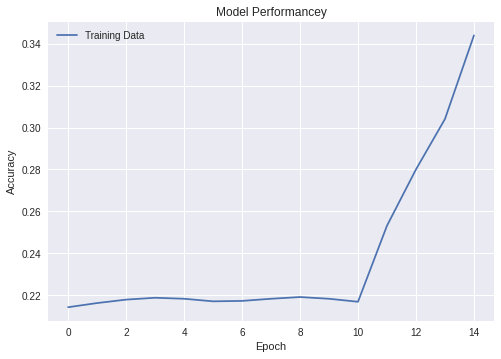

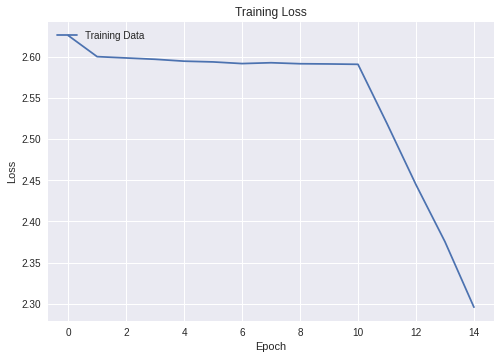

In [ ]:
plt.style.use('seaborn')
plt.plot(history.history['accuracy'])
# plt.plot(history.history['val_accuracy'])
plt.title('Model Performancey')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Training Data', 'Test Data'], loc='upper left')
plt.savefig('accuracy.png')
plt.savefig('accuracy.svg') #preferred in LaTeX
plt.show()

plt.plot(history.history['loss'])
# plt.plot(history.history['val_loss'])
plt.title('Training Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Training Data', 'Test Data'], loc='upper left')
plt.savefig('loss.png')
plt.savefig('loss.svg')
plt.show()

In [ ]:
"""
- QUESTION: what label to give to an anime ? ? ? ? ? ? ? ? ? Answer: assign weights to labels

- multi-label classification can be acheived using Vowpal Wabbit: https://towardsdatascience.com/multi-label-classification-using-vowpal-wabbit-from-why-to-how-c1451ca0ded5
 https://www.pyimagesearch.com/2018/05/07/multi-label-classification-with-keras/

 - https://medium.com/analytics-vidhya/text-classification-using-word-embeddings-and-deep-learning-in-python-classifying-tweets-from-6fe644fcfc81

- Possible different Word Embedding model, TF-IDF and Smooth Inverse Frequency (SIF): https://monkeylearn.com/blog/what-is-tf-idf/
 https://intellica-ai.medium.com/comparison-of-different-word-embeddings-on-text-similarity-a-use-case-in-nlp-e83e08469c1c
 https://towardsdatascience.com/creating-word-embeddings-coding-the-word2vec-algorithm-in-python-using-deep-learning-b337d0ba17a8
 https://medium.com/analytics-vidhya/text-classification-using-word-embeddings-and-deep-learning-in-python-classifying-tweets-from-6fe644fcfc81
 https://analyticsindiamag.com/hands-on-guide-to-word-embeddings-using-glove/
"""